# 281 Final Project

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import urllib
import os
import cv2

import skimage
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from sklearn.manifold import TSNE

In [34]:
test_path = './seg_test/seg_test/'
train_path = './seg_train/seg_train/'

In [35]:
def dataframe_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    building_path = 'buildings/'
    forest_path = 'forest/'
    glacier_path = 'glacier/'
    mountain_path = 'mountain/'
    sea_path = 'sea/'
    street_path = 'street/'
    
    building_path = os.path.join(filepath, building_path)
    forest_path = os.path.join(filepath, forest_path)
    glacier_path = os.path.join(filepath, glacier_path)
    mountain_path = os.path.join(filepath, mountain_path)
    sea_path = os.path.join(filepath, sea_path)
    street_path = os.path.join(filepath, street_path)

    def get_files_with_labels(folder_path, label):
        files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith('.jpg')]
        labels = [label] * len(files)
        return files, labels

    building_files, building_list = get_files_with_labels(building_path, 'building')
    forest_files, forest_list = get_files_with_labels(forest_path, 'forest')
    glacier_files, glacier_list = get_files_with_labels(glacier_path, 'glacier')
    mountain_files, mountain_list = get_files_with_labels(mountain_path, 'mountain')
    sea_files, sea_list = get_files_with_labels(sea_path, 'sea')
    street_files, street_list = get_files_with_labels(street_path, 'street')

    paths = building_files + forest_files + glacier_files + mountain_files + sea_files + street_files
    labels = building_list + forest_list + glacier_list + mountain_list + sea_list + street_list

    df = pd.DataFrame({'files': paths, 'labels': labels})

    return df

In [36]:
#Create dataframe and split train/validation
df = dataframe_img(train_path)

# Define the percentage of data to assign to the validation set
validation_split = 0.2

# Create an empty 'train_or_val' column
df['train_or_val'] = 'training'

# Group the data by 'labels'
groups = df.groupby('labels')

# Update 10% of rows for each label to 'validation'
for name, group in groups:
    num_validation_samples = int(len(group) * validation_split)
    validation_indices = np.random.choice(group.index, num_validation_samples, replace=False)
    df.loc[validation_indices, 'train_or_val'] = 'validation'
    

In [37]:
df_train = df[df['train_or_val']=='training'].reset_index().drop('index', axis=1)
df_val = df[df['train_or_val']=='validation'].reset_index().drop('index', axis=1)
df_test =  dataframe_img(test_path)

In [38]:
df_train['labels'].unique()

array(['building', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

In [39]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):
    # Check if the file path ends with ".jpg"
    if in_path.lower().endswith('.jpg'):
        img = cv2.imread(in_path, 0)

        # Histogram equalization
        # img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
        # img = cv2.equalizeHist(img)

        # Convert to floating-point image with intensity [0, 1]
        if np.max(img) > 1:
            img = img.astype(np.float32) / 255.0

        standard = 150
        scale = standard / min(img.shape[:2])
        img = rescale(img, scale, anti_aliasing=False)
        img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
                  int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]

        img = skimage.img_as_ubyte(img)

        return img

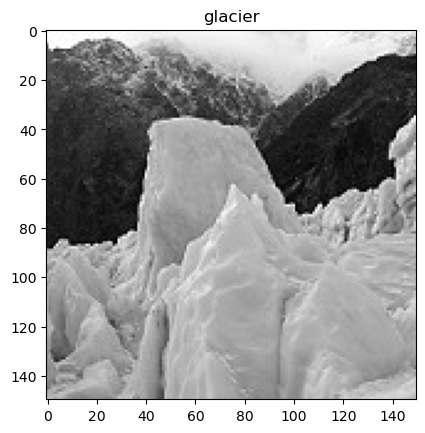

(150, 150)

In [41]:
# Load the image from a file
img = read_image(df_train['files'][5000])
# Get the label for the image
label = df_train['labels'][5000]
# Display the image
plt.imshow(img, cmap='gray')  # 'cmap' specifies the colormap for grayscale
plt.title(label)  # Set the title to the label
plt.show()

img.shape

In [42]:
img_building = read_image(df_train[df_train['labels']=='building']['files'].to_list()[0])
img_street = read_image(df_train[df_train['labels']=='street']['files'].to_list()[0])
img_forest = read_image(df_train[df_train['labels']=='forest']['files'].to_list()[0])
img_glacier = read_image(df_train[df_train['labels']=='glacier']['files'].to_list()[0])
img_mountain = read_image(df_train[df_train['labels']=='mountain']['files'].to_list()[0])
img_sea = read_image(df_train[df_train['labels']=='sea']['files'].to_list()[0])

In [43]:
for img in [img_building, img_street, img_forest, img_glacier, img_mountain, img_sea]:
    img = skimage.img_as_ubyte(img)
    GLCM = graycomatrix(img, [16], [0, np.pi/4, np.pi/2, 3*np.pi/2])
    a= graycoprops(GLCM, 'energy')[0,0]

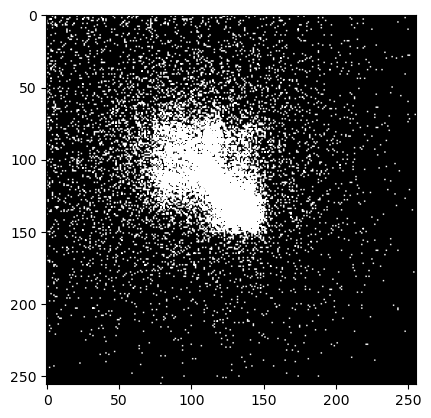

In [44]:
plt.imshow(GLCM[:,:,0,0], cmap='gray', vmin=0, vmax=1)

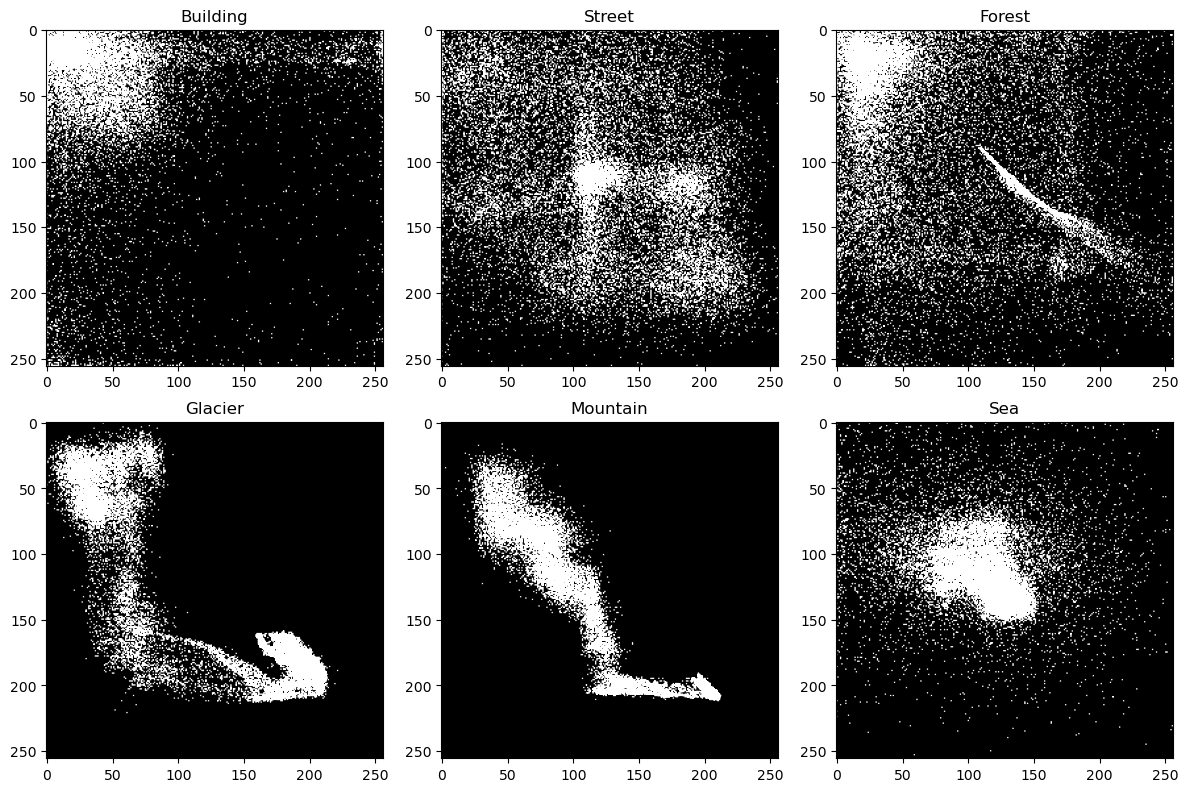

In [45]:
# Convert images to uint8
imgs = {
    'Building': img_building,
    'Street': img_street,
    'Forest': img_forest,
    'Glacier': img_glacier,
    'Mountain': img_mountain,
    'Sea': img_sea
}

imgs_uint8 = {name: skimage.img_as_ubyte(img) for name, img in imgs.items()}

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over images and plot
for (name, img), ax in zip(imgs_uint8.items(), axs.ravel()):
    GLCM = graycomatrix(img, [16], [0, np.pi/4, np.pi/2, 3*np.pi/2])
    energy = graycomatrix(img, [16], [0, np.pi/4, np.pi/2, 3*np.pi/2])
    ax.imshow(GLCM[:,:,0,2], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'{name}')

plt.tight_layout()
plt.show()

In [46]:
def GLCM_extractor(file_series):
    glcm_dataset = pd.DataFrame()
    
    for file in file_series:
        img = read_image(file)
        img = skimage.img_as_ubyte(img)
        
        for size in [1, 4, 16]:
            for angle in [0, np.pi/4, np.pi/2, 3*np.pi/2]:
                df = pd.DataFrame()
                df['file']=str(file)
                df['size']=int(size)
                df['angle']=float(angle)
                
                GLCM = graycomatrix(img, [size], [angle])
                GLCM_Energy = graycoprops(GLCM, 'energy')[0]
                df['energy']= GLCM_Energy
                GLCM_corr = graycoprops(GLCM, 'correlation')[0]
                df['corr'] = GLCM_corr
                GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
                df['diss'] = GLCM_diss
                GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
                df['homogen'] = GLCM_hom
                GLCM_contr = graycoprops(GLCM, 'contrast')[0]
                df['contr'] = GLCM_contr
                
                df['file']=str(file)
                df['size']=int(size)
                df['angle']=float(angle)
                
                glcm_dataset = pd.concat([glcm_dataset, df])
    return glcm_dataset

In [47]:
glcm_dataset = GLCM_extractor(df['files'])

In [48]:
glcm_dataset

,file,size,angle,energy,corr,diss,homogen,contr
0,./seg_train/seg_train/buildings/12536.jpg,1,0.000000,0.052318,0.680004,18.688501,0.279987,1400.244385
0,./seg_train/seg_train/buildings/12536.jpg,1,0.785398,0.044929,0.557719,21.621954,0.237501,1941.219990
0,./seg_train/seg_train/buildings/12536.jpg,1,1.570796,0.049742,0.708366,16.677494,0.274435,1281.880447
0,./seg_train/seg_train/buildings/12536.jpg,1,4.712389,0.049742,0.708366,16.677494,0.274435,1281.880447
0,./seg_train/seg_train/buildings/12536.jpg,4,0.000000,0.037345,0.303219,29.135114,0.173023,3032.808082
...,...,...,...,...,...,...,...,...
0,./seg_train/seg_train/street/8434.jpg,4,4.712389,0.034628,0.757816,27.386438,0.094284,1909.200959
0,./seg_train/seg_train/street/8434.jpg,16,0.000000,0.020821,0.357075,54.412637,0.044979,5227.975025
0,./seg_train/seg_train/street/8434.jpg,16,0.785398,0.023173,0.396109,52.249677,0.048328,4764.548212
0,./seg_train/seg_train/street/8434.jpg,16,1.570796,0.022012,0.529914,43.702587,0.057753,3710.645075


In [49]:
df=df.rename({'files':'file'}, axis=1)
df

,file,labels,train_or_val
0,./seg_train/seg_train/buildings/12536.jpg,building,training
1,./seg_train/seg_train/buildings/16750.jpg,building,training
2,./seg_train/seg_train/buildings/16988.jpg,building,training
3,./seg_train/seg_train/buildings/4571.jpg,building,training
4,./seg_train/seg_train/buildings/12244.jpg,building,training
...,...,...,...
14029,./seg_train/seg_train/street/14638.jpg,street,training
14030,./seg_train/seg_train/street/15526.jpg,street,training
14031,./seg_train/seg_train/street/18002.jpg,street,validation
14032,./seg_train/seg_train/street/10338.jpg,street,training


In [50]:
final_glcm = pd.merge(glcm_dataset, df, how='outer', on='file')

In [51]:
final_glcm.to_csv('glcm_dataset')

In [52]:
train_glcm = final_glcm[final_glcm['train_or_val']=='training']

In [53]:
train_glcm['angle']=round(train_glcm['angle'],2)

/var/folders/vp/44qg_5jx7d930swm8chs53w80000gn/T/ipykernel_7681/3113386936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_glcm['angle']=round(train_glcm['angle'],2)


In [54]:
train_glcm['angle'].value_counts()

angle
0.00    33690
0.79    33690
1.57    33690
4.71    33690
Name: count, dtype: int64

In [55]:
size = 16
angle = 1.57
train_glcm_graph = train_glcm[(train_glcm['angle']==angle) & (train_glcm['size']==size)]

In [56]:
train_glcm[train_glcm['size']==size]

,file,size,angle,energy,corr,diss,homogen,contr,labels,train_or_val
8,./seg_train/seg_train/buildings/12536.jpg,16,0.00,0.027590,0.080895,34.947960,0.089653,3881.665970,building,training
9,./seg_train/seg_train/buildings/12536.jpg,16,0.79,0.029584,0.124331,34.014337,0.096741,3807.227731,building,training
10,./seg_train/seg_train/buildings/12536.jpg,16,1.57,0.028949,0.155472,34.208706,0.094998,3824.237264,building,training
11,./seg_train/seg_train/buildings/12536.jpg,16,4.71,0.028949,0.155472,34.208706,0.094998,3824.237264,building,training
20,./seg_train/seg_train/buildings/16750.jpg,16,0.00,0.013308,0.072095,65.847164,0.069914,8533.059403,building,training
...,...,...,...,...,...,...,...,...,...,...
168371,./seg_train/seg_train/street/15526.jpg,16,4.71,0.015915,0.553853,48.612090,0.044148,4462.106816,street,training
168392,./seg_train/seg_train/street/10338.jpg,16,0.00,0.012532,0.250957,52.497363,0.049177,5264.076269,street,training
168393,./seg_train/seg_train/street/10338.jpg,16,0.79,0.011315,-0.004796,66.386108,0.032386,7227.302314,street,training
168394,./seg_train/seg_train/street/10338.jpg,16,1.57,0.012442,0.083329,61.916318,0.038211,6673.271940,street,training


In [57]:
# Create a pivot table with 'size', 'angle', and 'energy' as the values
pivot_df = train_glcm.pivot_table(index=['file', 'labels', 'train_or_val'],
                          columns=['size', 'angle'],
                          values=['energy', 'corr', 'diss', 'homogen', 'contr'],
                          aggfunc='first')  # You can choose a different aggregation function if needed
pivot_df.columns = [f'{value}_{size}_{angle:.2f}' for value,size, angle in pivot_df.columns]

In [58]:
pivot_df=pivot_df.reset_index()

## Create tSNE

In [26]:
pivot_df.columns

Index(['file', 'labels', 'train_or_val', 'contr_1_0.00', 'contr_1_0.79',
       'contr_1_1.57', 'contr_1_4.71', 'contr_4_0.00', 'contr_4_0.79',
       'contr_4_1.57', 'contr_4_4.71', 'contr_16_0.00', 'contr_16_0.79',
       'contr_16_1.57', 'contr_16_4.71', 'corr_1_0.00', 'corr_1_0.79',
       'corr_1_1.57', 'corr_1_4.71', 'corr_4_0.00', 'corr_4_0.79',
       'corr_4_1.57', 'corr_4_4.71', 'corr_16_0.00', 'corr_16_0.79',
       'corr_16_1.57', 'corr_16_4.71', 'diss_1_0.00', 'diss_1_0.79',
       'diss_1_1.57', 'diss_1_4.71', 'diss_4_0.00', 'diss_4_0.79',
       'diss_4_1.57', 'diss_4_4.71', 'diss_16_0.00', 'diss_16_0.79',
       'diss_16_1.57', 'diss_16_4.71', 'energy_1_0.00', 'energy_1_0.79',
       'energy_1_1.57', 'energy_1_4.71', 'energy_4_0.00', 'energy_4_0.79',
       'energy_4_1.57', 'energy_4_4.71', 'energy_16_0.00', 'energy_16_0.79',
       'energy_16_1.57', 'energy_16_4.71', 'homogen_1_0.00', 'homogen_1_0.79',
       'homogen_1_1.57', 'homogen_1_4.71', 'homogen_4_0.00', 'homog

In [27]:
pivot_df['train_or_val'].unique()

array(['training'], dtype=object)

In [28]:
X = pivot_df[['contr_1_0.00', 'contr_1_0.79',
       'contr_1_1.57', 'contr_1_4.71', 'contr_4_0.00', 'contr_4_0.79',
       'contr_4_1.57', 'contr_4_4.71', 'contr_16_0.00', 'contr_16_0.79',
       'contr_16_1.57', 'contr_16_4.71', 'corr_1_0.00', 'corr_1_0.79',
       'corr_1_1.57', 'corr_1_4.71', 'corr_4_0.00', 'corr_4_0.79',
       'corr_4_1.57', 'corr_4_4.71', 'corr_16_0.00', 'corr_16_0.79',
       'corr_16_1.57', 'corr_16_4.71', 'diss_1_0.00', 'diss_1_0.79',
       'diss_1_1.57', 'diss_1_4.71', 'diss_4_0.00', 'diss_4_0.79',
       'diss_4_1.57', 'diss_4_4.71', 'diss_16_0.00', 'diss_16_0.79',
       'diss_16_1.57', 'diss_16_4.71', 'energy_1_0.00', 'energy_1_0.79',
       'energy_1_1.57', 'energy_1_4.71', 'energy_4_0.00', 'energy_4_0.79',
       'energy_4_1.57', 'energy_4_4.71', 'energy_16_0.00', 'energy_16_0.79',
       'energy_16_1.57', 'energy_16_4.71', 'homogen_1_0.00', 'homogen_1_0.79',
       'homogen_1_1.57', 'homogen_1_4.71', 'homogen_4_0.00', 'homogen_4_0.79',
       'homogen_4_1.57', 'homogen_4_4.71', 'homogen_16_0.00',
       'homogen_16_0.79', 'homogen_16_1.57', 'homogen_16_4.71']]
y = pivot_df['labels']

In [231]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Labels'] = y

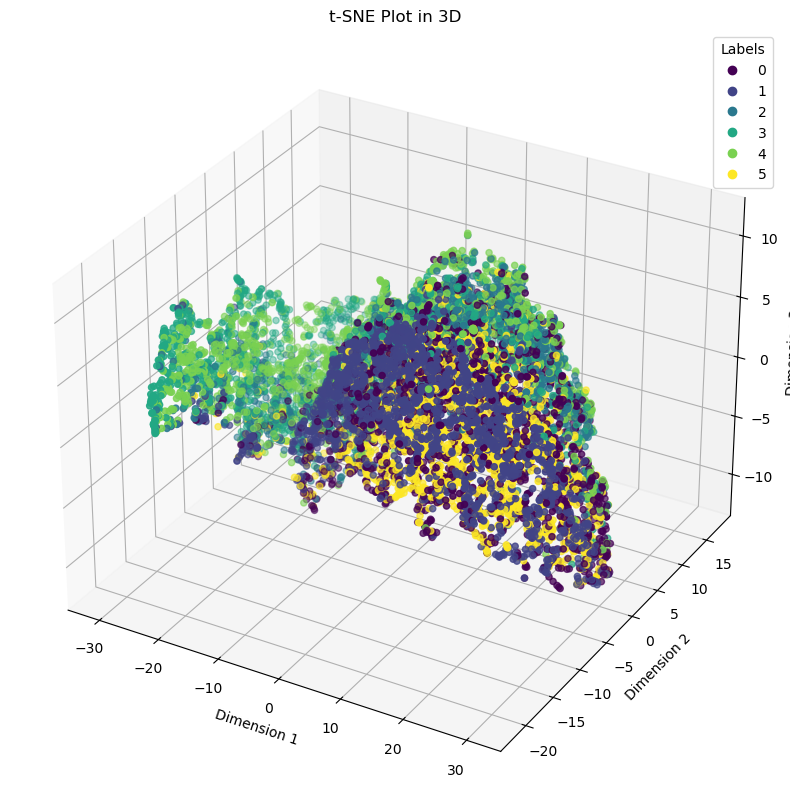

In [129]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Scatter plot with colors based on labels
scatter = ax.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], tsne_df['Dimension 3'], c=pd.Categorical(tsne_df['Labels']).codes, cmap='viridis')

# Create a custom legend with label names
legend = ax.legend(*scatter.legend_elements(), title='Labels')

# Set labels
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('t-SNE Plot in 3D')

plt.show()


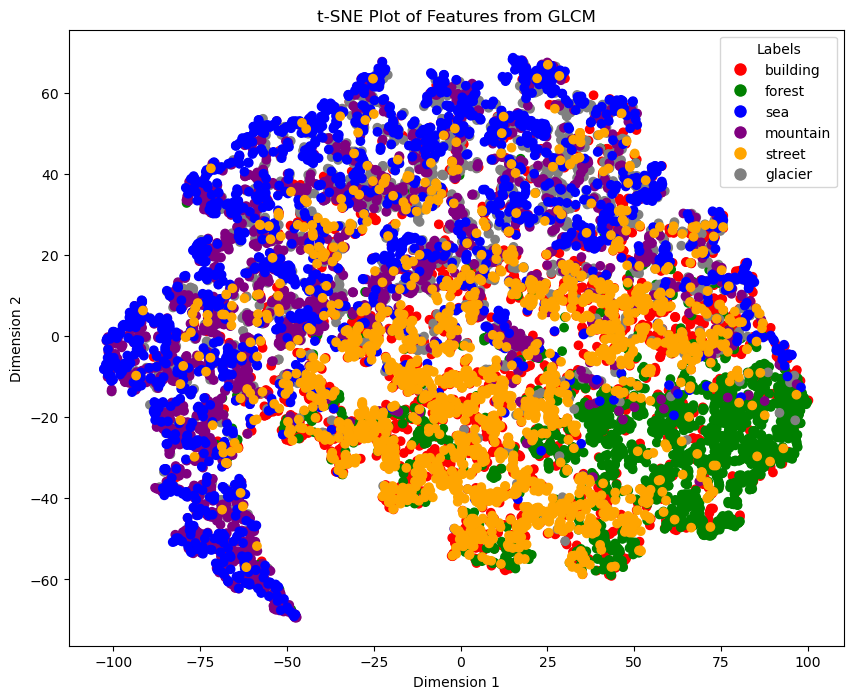

In [232]:
# Define custom colors for each label
label_colors = {'building': 'red', 'forest': 'green', 'sea': 'blue', 'mountain': 'purple', 'street': 'orange', 'glacier': 'grey'}

# Plot the results
plt.figure(figsize=(10, 8))

# Scatter plot with custom colors
scatter = plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'], c=tsne_df['Labels'].map(label_colors))

# Add a legend with custom colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_colors[label], markersize=10, label=label) for label in label_colors]
plt.legend(handles=legend_labels, title='Labels')

plt.title('t-SNE Plot of Features from GLCM')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [99]:
pd.factorize(tsne_df['Labels'])

(array([0, 0, 0, ..., 5, 5, 5]),
 Index(['building', 'forest', 'glacier', 'mountain', 'sea', 'street'], dtype='object'))

## Create Histograms

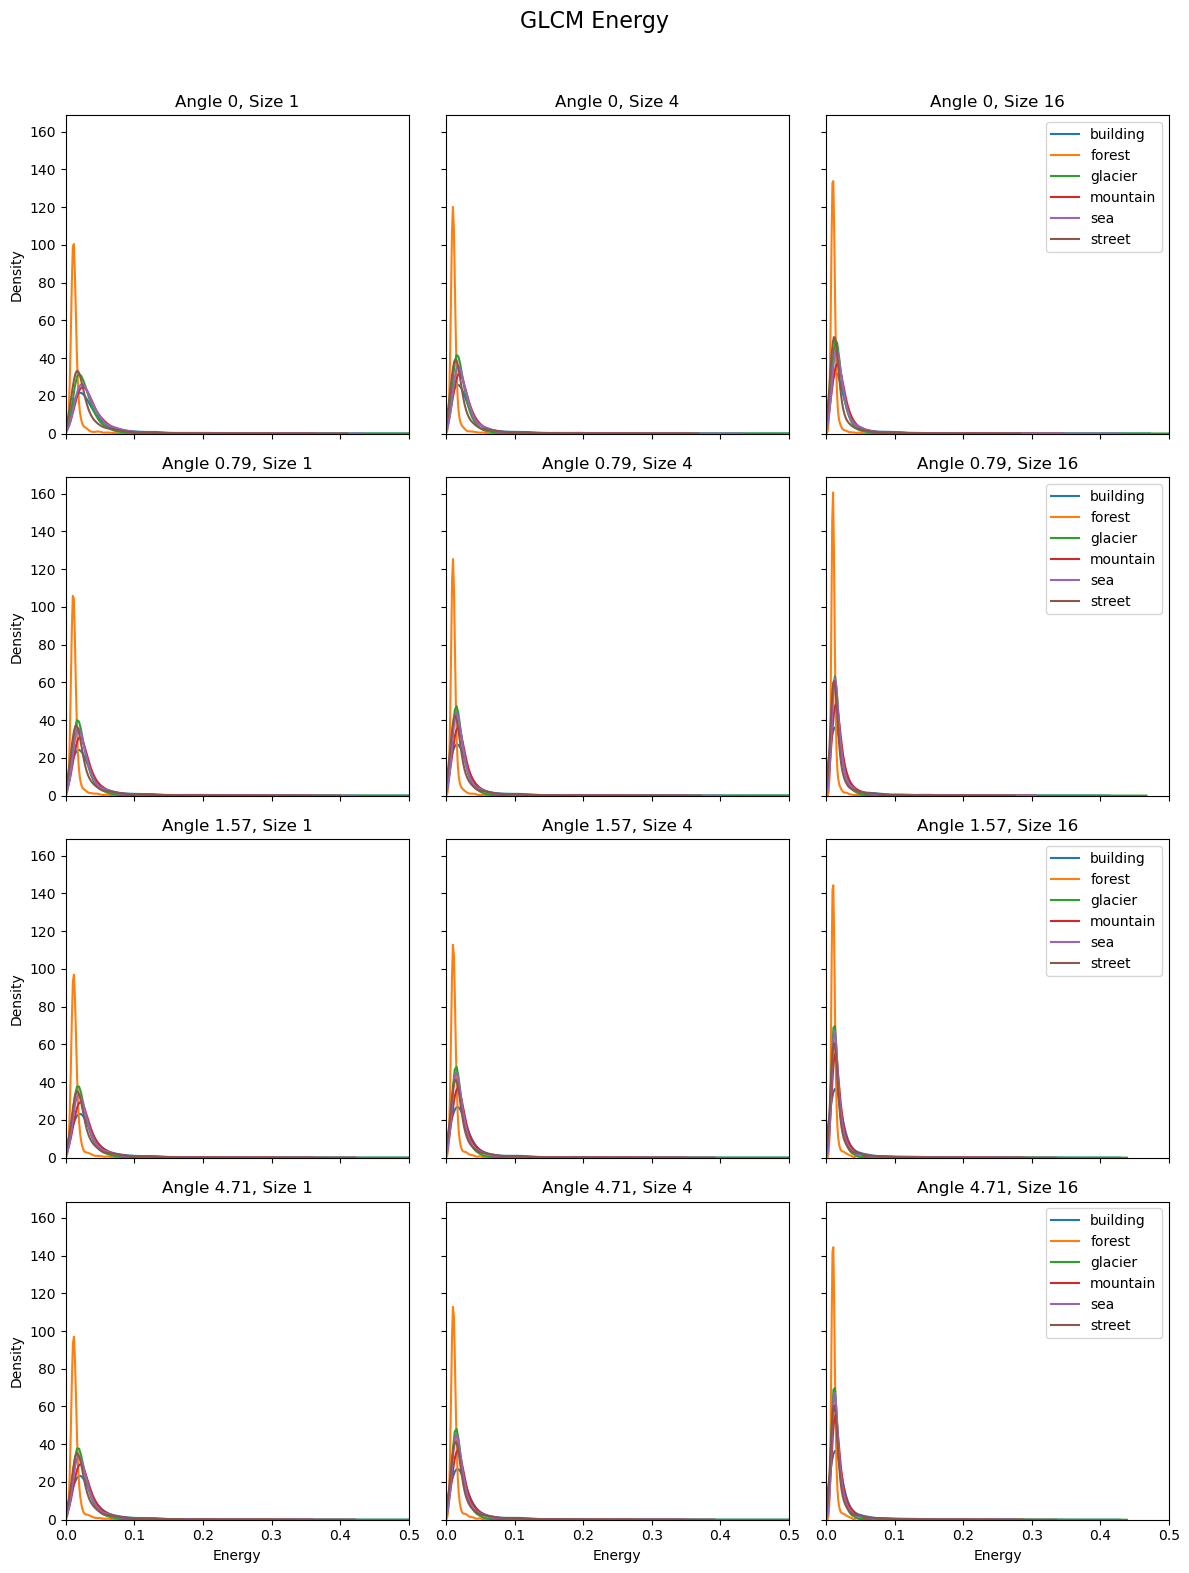

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of sizes
sizes = [1, 4, 16]

# List of angles
angles = [0, 0.79, 1.57, 4.71]

# Create subplots with multiple columns
fig, axes = plt.subplots(nrows=len(angles), ncols=len(sizes), figsize=(4*len(sizes), 4*len(angles)),  sharey=True, sharex=True)

for i, angle in enumerate(angles):
    for j, size in enumerate(sizes):
        
        train_glcm_graph = train_glcm[(train_glcm['angle'] == angle) & (train_glcm['size'] == size)]

        for label in train_glcm_graph['labels'].unique():
            sns.kdeplot(train_glcm_graph[train_glcm_graph['labels'] == label]['energy'], label=label, ax=axes[i, j])

        axes[i, j].set_xlabel('Energy')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_title(f'Angle {angle}, Size {size}')

        # Set custom x-axis limits
        axes[i, j].set_xlim(0, 0.5)  # Replace min_custom_value and max_custom_value with your desired values

        # Display legend for the last subplot
        if j == len(sizes) - 1:
            axes[i, j].legend()

fig.suptitle('GLCM Energy', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

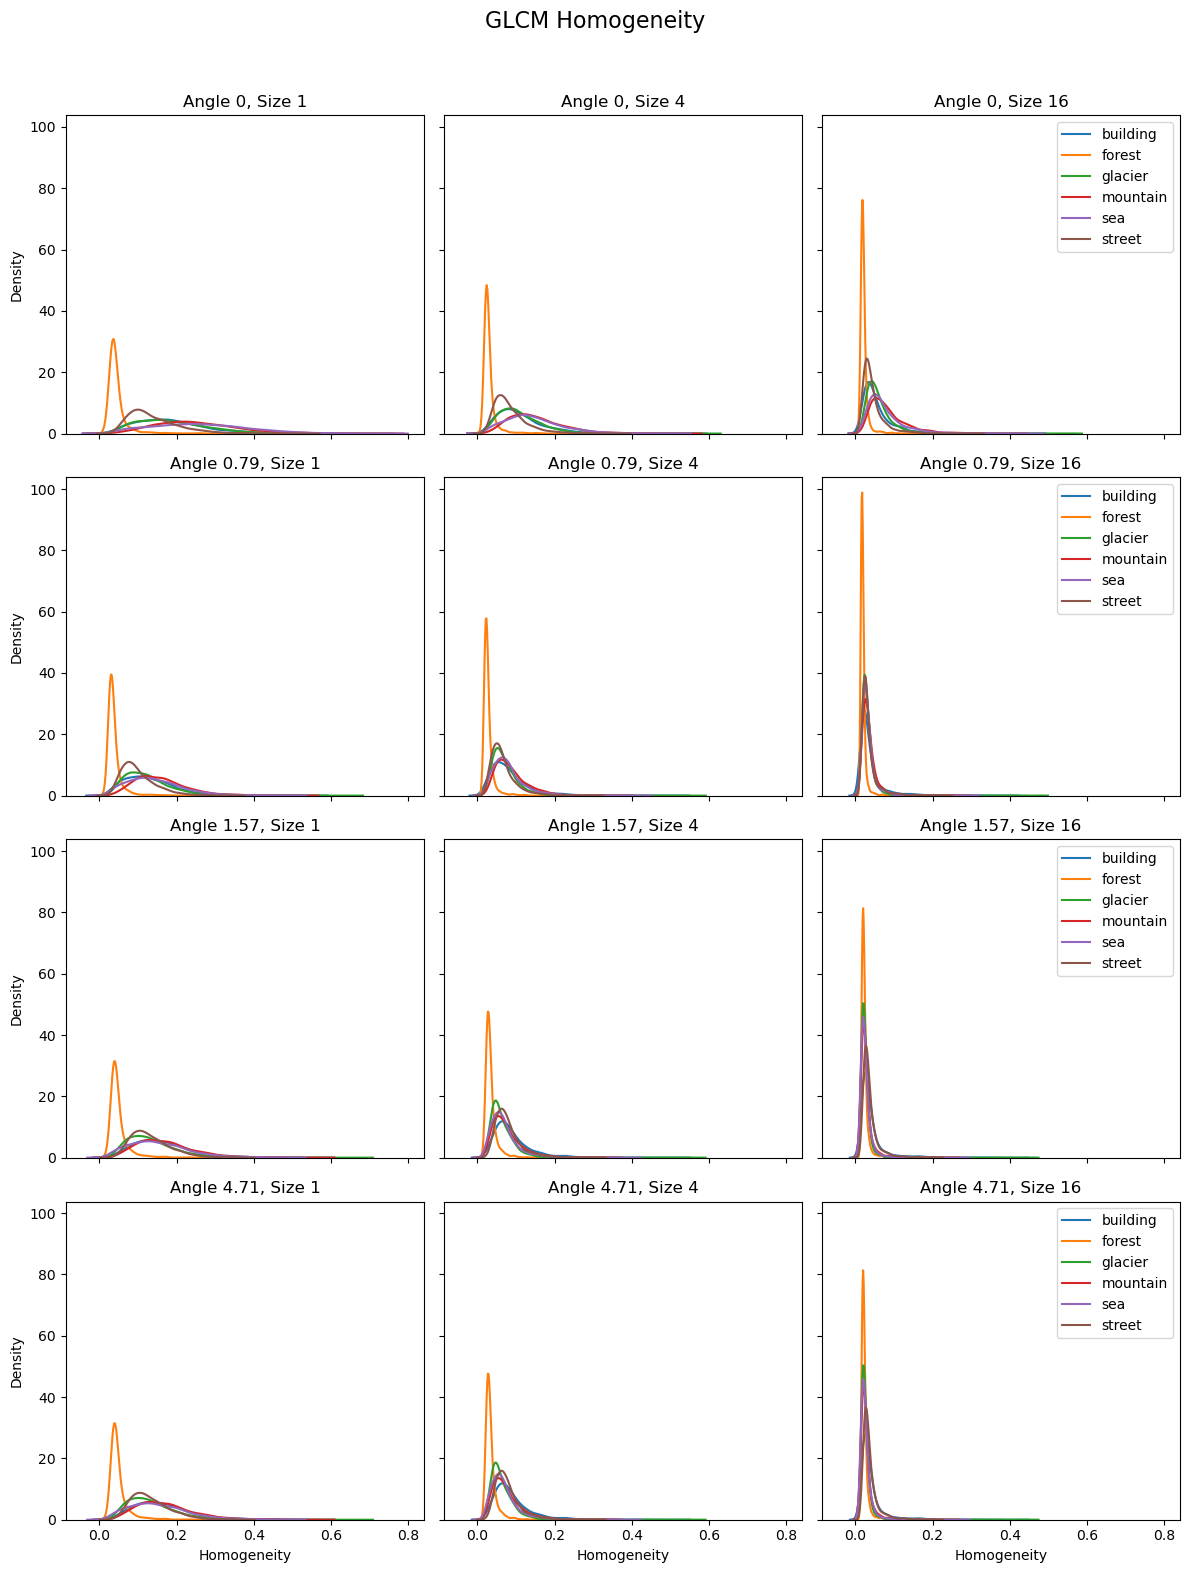

In [227]:
# List of sizes
sizes = [1, 4, 16]

# List of angles
angles = [0, 0.79, 1.57, 4.71]

# Create subplots with multiple columns
fig, axes = plt.subplots(nrows=len(angles), ncols=len(sizes), figsize=(4*len(sizes), 4*len(angles)),  sharey=True, sharex=True)

for i, angle in enumerate(angles):
    for j, size in enumerate(sizes):
        
        train_glcm_graph = train_glcm[(train_glcm['angle'] == angle) & (train_glcm['size'] == size)]

        for label in train_glcm_graph['labels'].unique():
            sns.kdeplot(train_glcm_graph[train_glcm_graph['labels'] == label]['homogen'], label=label, ax=axes[i, j])

        axes[i, j].set_xlabel('Homogeneity')
        axes[i, j].set_ylabel('Density')
        axes[i, j].set_title(f'Angle {angle}, Size {size}')

        # Display legend for the last subplot
        if j == len(sizes) - 1:
            axes[i, j].legend()

fig.suptitle('GLCM Homogeneity', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()